# CEIA - Análisis de Datos
## Trabajo Práctico Número 2

### Grupo: 

          - Martín A. Brocca 
          - Agustín A. Lopez Fredes 

Dataset seleccionado: [AirBnB Dataset](https://insideairbnb.com/get-the-data/)

In [1]:
# importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd
from shapely.geometry import Point
import missingno as msno



#### De acuerdo a lo realizado en el TP1, el problema seleccionado cuenta con un dataset conformado por 7 archivos:
| **Archivo**                | **Descripción**                                                                 |
|------------------------|------------------------------------------------------------------------------|
| Listing.csv.gz         | Listado detallado de inmuebles                                               |
| Calendar.csv.gz        | Información detallada de fechas de reserva y ocupación                       |
| Reviews.csv.gz         | Listado detallado de opiniones y valoraciones de usuarios                    |
| Listing.csv            | Versión resumida del listado de inmuebles para facilitar visualizaciones     |
| Neighbourhoods.csv     | Listado de barrios de la localidad                                           |
| Neighbourhoods.geojson | Archivo GeoJson con los barrios de la localidad                              |


El dataset corresponde a los últimos 12 meses a cierre de Enero 2025.

Se utilizarán los archivos detallados para el EDA, como así también el archivo geojson para la representación gráfica de algunas conclusiones o reportes.


In [2]:
#  URL para descargar todos los archivos que conforman el dataset
data_base_url = "https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2025-01-29"


# Definimos los nombres de los archivos y sus correspondientes URLs
data_files = {
    "df_listings_details": "/data/listings.csv.gz",
    "df_reviews_details": "/data/reviews.csv.gz",
    "df_calendar": "/data/calendar.csv.gz",
    "df_listings": "/visualisations/listings.csv",
    "df_reviews": "/visualisations/reviews.csv",
    "df_neighbourhoods": "/visualisations/neighbourhoods.csv",
}


# Carga directa de los archivos CSV desde la URL
dfs = {
    #name: pd.read_csv(base_url + filename, compression="gzip" if filename.endswith(".gz") else None)
    name: pd.read_csv(data_base_url + filename)
    for name, filename in data_files.items()
}
# Carga del archivo GeoJSON
dfs["df_neighbourhoods_geojson"] = gpd.read_file(
    data_base_url + "/visualisations/neighbourhoods.geojson"
)


In [3]:
# Creación de las variables individuales.
df_listings_details = dfs["df_listings_details"]
df_neighborhoods = dfs["df_neighbourhoods"]
df_reviews_details = dfs["df_reviews_details"]
df_calendar = dfs["df_calendar"]

In [11]:
# Convertimos el precio en float, limpiando los caracteres previamente
# Elimina símbolo de dólar, comas y espacios, luego convierte a float
df_listings_details['price'] = (
    df_listings_details['price']
    .replace('[\$,]', '', regex=True)  # quita $ y ,
    .astype(float)
)

Para el caso de listings, debido a que el dataset cuenta con 45 columnas, en el TP1 determinamos aquellas de interés:

In [44]:
df_listings_details_interes = df_listings_details[['id','property_type', 'room_type', 
                                           'name', 'description','accommodates', 'bedrooms', 'beds', 
                                            'bathrooms','price', 'availability_eoy',
                                            'estimated_occupancy_l365d', 'review_scores_rating',
                                            'review_scores_accuracy', 'review_scores_cleanliness',                                                     'review_scores_checkin', 'review_scores_communication',
                                            'review_scores_location','latitude', 'longitude', 
                                            'review_scores_value','number_of_reviews','reviews_per_month', 
                                            'neighbourhood', 'neighbourhood_cleansed',
                                            'host_identity_verified', 'host_has_profile_pic']]

Además, generamos los features de precio por habitación, cama y baño de acuerdo a lo analizado en el TP1:

In [45]:
df_listings_details_interes['precio_habitacion'] = df_listings_details_interes['price'] / df_listings_details_interes['bedrooms']
df_listings_details_interes['precio_cama'] = df_listings_details_interes['price'] / df_listings_details_interes['beds']
df_listings_details_interes['precio_baño'] = df_listings_details_interes['price'] / df_listings_details_interes['bathrooms']

C:\Users\alope\AppData\Local\Temp\ipykernel_7604\3005531904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes['precio_habitacion'] = df_listings_details_interes['price'] / df_listings_details_interes['bedrooms']
C:\Users\alope\AppData\Local\Temp\ipykernel_7604\3005531904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes['precio_cama'] = df_listings_details_interes['price'] / df_listings_details_interes['beds']
C:\Users\alope\AppData\Local\Temp\ipyk

Queremos predecir el nivel de ocupación que tendrá cada propiedad, por lo que el target será el nivel de disponibilidad anual de los listings ('availability_eoy'). Esta variable muestra la cantidad de días que una propiedad estuvo disponible en el año, por lo que es el complemento de la ocupación.

En el TP1 se analizaron los valores faltantes y outliers. Repasamos las cantidades para determinar si se eliminan las filas/columnas o se imputan:

In [46]:
# Función para informar las columnas con mayor cantidad de datos faltantes orderadas de mayor a menor
def report_missing(df):
    missing_report = (
        df.isnull().sum()
        .to_frame(name='missing_count')
        .assign(missing_pct=lambda x: (x['missing_count'] / len(df)) * 100)
        .sort_values(by='missing_count', ascending=False)
    )
    return missing_report

In [47]:
# Función auxiliar para detectar outliers
def detectar_outliers(df):
    # Seleccionar solo columnas numéricas
    columnas_numericas = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in columnas_numericas:
        # Calcular IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Límites para IQR con umbral 1.5
        limite_inferior_iqr_1_5 = Q1 - 1.5 * IQR
        limite_superior_iqr_1_5 = Q3 + 1.5 * IQR
        
        # Límites para IQR con umbral 3 (outliers severos)
        limite_inferior_iqr_3 = Q1 - 3 * IQR
        limite_superior_iqr_3 = Q3 + 3 * IQR

        # Calcular media y desviación estándar (umbral fijo de 3)
        mean = df[col].mean()
        std = df[col].std()
        limite_inferior_std = mean - 3 * std
        limite_superior_std = mean + 3 * std

        # Identificar outliers
        outliers_iqr_1_5 = df[(df[col] < limite_inferior_iqr_1_5) | (df[col] > limite_superior_iqr_1_5)]
        outliers_iqr_3 = df[(df[col] < limite_inferior_iqr_3) | (df[col] > limite_superior_iqr_3)]
        outliers_std = df[(df[col] < limite_inferior_std) | (df[col] > limite_superior_std)]

        # Calcular porcentajes
        total_data_points = len(df[col].dropna())
        outlier_percentage_iqr_1_5 = (len(outliers_iqr_1_5) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_iqr_3 = (len(outliers_iqr_3) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_std = (len(outliers_std) / total_data_points) * 100 if total_data_points > 0 else 0

        # Guardar resultados
        results.append({
            'Columna': col,
            'Porcentaje Outliers (Umbral 1.5 * IQR)': round(outlier_percentage_iqr_1_5, 2),
            'Porcentaje Outliers Severos (Umbral 3 * IQR)': round(outlier_percentage_iqr_3, 2),
            'Porcentaje Outliers (Umbral 3 * STD)': round(outlier_percentage_std, 2)
        })

    # Convertir resultados a DataFrame
    result_df = pd.DataFrame(results)
    
    # Ordenar por porcentaje de outliers (Umbral 1.5 * IQR) de mayor a menor
    result_df_sorted = result_df.sort_values(by='Porcentaje Outliers (Umbral 1.5 * IQR)', ascending=False)
    
    # Generar gráfico de barras con Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=result_df_sorted,
        x='Columna',
        y='Porcentaje Outliers (Umbral 1.5 * IQR)',
        color='#4e79a7'  # Azul oscuro compatible con temas claros y oscuros
    )
    plt.title('Porcentaje de Outliers por Columna (Umbral 1.5 * IQR)')
    plt.xlabel('Columnas')
    plt.ylabel('Porcentaje de Outliers (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return result_df

#### Valores faltantes
##### Listings

In [48]:
report_missing(df_listings_details_interes)

,missing_count,missing_pct
neighbourhood,18584,52.837484
review_scores_value,5761,16.379506
review_scores_accuracy,5761,16.379506
review_scores_checkin,5760,16.376663
review_scores_rating,5760,16.376663
reviews_per_month,5760,16.376663
review_scores_location,5760,16.376663
review_scores_communication,5760,16.376663
review_scores_cleanliness,5760,16.376663
precio_habitacion,3613,10.272376


Para 'neighbourhood', observamos que la podemos reemplazar variable 'neighbourhood_cleansed' que no tiene faltantes, por lo que la eliminamos. Para el resto haremos imputaciones (previo split train/test) 

In [49]:
df_listings_details_interes.drop(columns=['neighbourhood'], inplace=True)

C:\Users\alope\AppData\Local\Temp\ipykernel_7604\411268501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes.drop(columns=['neighbourhood'], inplace=True)


##### Reviews

In [50]:
report_missing(df_reviews_details)

,missing_count,missing_pct
listing_id,0,0.0
id,0,0.0
date,0,0.0
reviewer_id,0,0.0
reviewer_name,0,0.0
comments,0,0.0


Sólo las columnas 'comments' y 'reviewer_name' tienen valores faltantes, pero al ser un porcentaje bajo, eliminamos las filas directamente:

In [51]:
df_reviews_details.dropna(inplace=True)

#### Outliers
##### Listings

c:\Users\alope\AppData\Local\pypoetry\Cache\virtualenvs\ceia-analisis-de-datos-QTP77gc6-py3.11\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\alope\AppData\Local\pypoetry\Cache\virtualenvs\ceia-analisis-de-datos-QTP77gc6-py3.11\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\alope\AppData\Local\pypoetry\Cache\virtualenvs\ceia-analisis-de-datos-QTP77gc6-py3.11\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


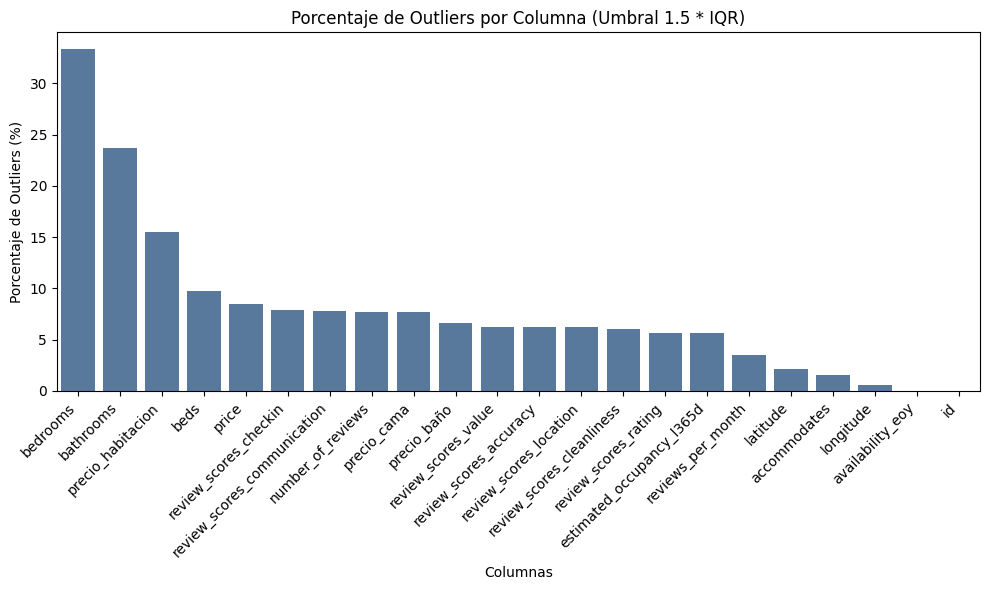

,Columna,Porcentaje Outliers (Umbral 1.5 * IQR),Porcentaje Outliers Severos (Umbral 3 * IQR),Porcentaje Outliers (Umbral 3 * STD)
0,id,0.00,0.00,0.00
1,accommodates,1.58,0.55,1.58
2,bedrooms,33.31,33.31,0.84
3,beds,9.74,2.05,1.20
4,bathrooms,23.74,23.74,1.47
5,price,8.52,4.09,0.11
6,availability_eoy,0.00,0.00,0.00
7,estimated_occupancy_l365d,5.62,0.00,0.00
8,review_scores_rating,5.67,1.92,1.66
9,review_scores_accuracy,6.26,3.37,1.60


In [52]:
porcentaje_outliers_listings = detectar_outliers(df_listings_details_interes)
porcentaje_outliers_listings

Se observa que en general el porcentaje de valores atípicos es bajo, aunque hay variables como bathrooms, bedrooms que contienen un porcentaje elevado según el criterio de IQR, no así por el criterio de la desviación estándar